### 基于最大间隔分隔数据

支持向量机的优缺点：

- 优点：泛化错误低，计算开销不大，结果易解释。
- 缺点：对参数调节和核函数的选择敏感，原始分类器不加修改仅适用于处理二类问题。
- 适用数据类型：数值型和标称型数据

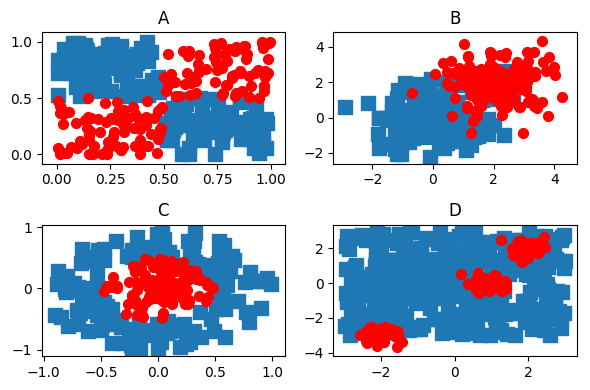

In [38]:
%run notLinSeperable.py

### SVM应用的一般框架

SVM的一般流程

1. 收集数据：可以使用任意方法。
2. 准备数据：需要数值型数据。
3. 分析数据：有助于可视化分隔超平面。
4. 训练算法：SVM的大部分时间都源自训练，该过程主要实现两个参数的调优。
5. 测试算法：十分简单的计算过程就可以实现。
6. 使用算法：几乎所有分类问题都可以使用SVM，SVM本来是一个二分类器，对多类问题应用SVM需要代码做一些代码。

### SMO高效优化算法

SMO表示**序列最小优化(Sequential Minimal Optimization)** 。Platt的SMO算法是将大优化问题分解为多个小优化问题来求解(分治思想)。此外，SMO算法的**求解时间很短** 。

SMO算法目标：求出一系列$\alpha$和b，一旦求出$\alpha$，就容易计算出权重向量w并得到分割超平面。

SMO算法工作原理：每次循环中选择两个$\alpha$进行优化处理。一旦找到一对合适的$\alpha$，那么就增大其中一个同时减少另一个。这里的“合适”就是指两个alpha必须要符合一定条件，条件之一为**这两个$\alpha$必须要在间隔边界之外**，第二个条件是**这两个$\alpha$还没有进行过区间化处理或不在边界上。**

#### 应用简化版SMO算法处理小规模数据集

Platt SMO算法中的外循环确定要优化的最佳$\alpha$对。而简化版会跳过这一部分，首先在数据集上遍历每个$\alpha$，然后在剩下的$\alpha$集合中随机选择另一个$\alpha$，从而构建$\alpha$对。有一点很重要，即**需要同时改变两个$\alpha$** ，是因为满足一个约束条件：

$$\sum \alpha_{i} \cdot label^{(i)} = 0$$

由于改变一个$\alpha$可能会导致该约束条件失效，因此我们总是同时改变两个$\alpha$。

In [39]:
import svmMLiA

In [40]:
import numpy as np

In [41]:
dataArr, labelArr = svmMLiA.loadDataSet('testSet.txt')

In [42]:
#dataArr

In [43]:
#labelArr 分类的结果是-1和1，而不是0和1

SMO函数的伪代码如下：

    创建一个$\alpha$向量并将其初始化为0的向量
    当迭代次数小于最大迭代次数时(外循环)
        对数据集中的每个数据向量(内循环)：
            如果该数据向量可以被优化：
                随机选择另外一个数据向量
                同时优化这两个向量
                如果两个向量都不能被优化，退出内循环
        如果所有向量都没被优化，增加迭代数目，继续下一次循环

In [44]:
reload(svmMLiA)

<module 'svmMLiA' from 'svmMLiA.pyc'>

In [45]:
#b, alphas = svmMLiA.smoSimple(dataArr, labelArr, 0.6, 0.001, 40)

In [46]:
b

-3.75567

In [47]:
alphas[alphas>0]

NameError: name 'alphas' is not defined

In [ ]:
np.shape(alphas[alphas>0])

In [ ]:
#输出支持向量
for i in range(100):
    if alphas[i] > 0.0:
        print dataArr[i], labelArr[i]

In [ ]:
dataMat = np.mat(dataArr)

In [ ]:
#dataMat[:,0].flatten().tolist()[0]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from matplotlib.patches import Circle

In [ ]:
fig = plt.figure()

In [ ]:
ax = fig.add_subplot(111)

In [ ]:
ax.scatter(dataMat[:,0].flatten().A[0], dataMat[:,1].flatten().A[0], s=10, c='red')

In [ ]:
#坐标表示要画圈的地方，第二个参数表示圈的大小，faceclolor表示，edgecolor表示圈的颜色值，linewidth表示圈的线条粗细，alpha表示颜色深浅
for i in range(100):
    if alphas[i] > 0.0:
        circle = Circle((dataArr[i][0], dataArr[i][1]), 0.2, facecolor='none', edgecolor=(0,0.8,0.8), linewidth=2, alpha=0.5)
        ax.add_patch(circle)

In [ ]:
#ax.scatter(dataMat[:,0].flatten().tolist()[0], dataMat[:,1].flatten().tolist()[0], s=10, c='red')

In [ ]:
plt.show()

### 利用完整的Platt SMO算法加速优化

Platt SMO算法是通过一个外循环来选择第一个$\alpha$值，并且其选择过程会在两种方式之间交替：一种方式是**在所有数据集上进行单遍扫描** ，另一种方式则是**在非边界$\alpha$中实现单遍扫描**。非边界$\alpha$是那么不等于0边界0或C的$\alpha$值。对整个数据集的扫描很容易，而实现非边界$\alpha$值扫描时，首先需要建立这些$\alpha$值的列表，然后再对这个表进行遍历。同时该步骤会跳过那些已知不变的$\alpha$值。

In [ ]:
reload(svmMLiA)

In [ ]:
dataArr, labelArr = svmMLiA.loadDataSet('testSet.txt')

In [ ]:
b, alphas = svmMLiA.smoP(dataArr, labelArr, 0.6, 0.001, 40)

In [ ]:
reload(svmMLiA)

In [ ]:
ws = svmMLiA.calcWs(alphas, dataArr, labelArr)

In [ ]:
ws

In [ ]:
dataMat = np.mat(dataArr)

In [ ]:
dataMat[0] * np.mat(ws) + b

In [ ]:
labelArr[0]

In [ ]:
dataMat[2] * np.mat(ws) + b

In [ ]:
labelArr[2]

In [ ]:
dataMat[1] * np.mat(ws) + b

In [ ]:
labelArr[1]

In [ ]:
%run plotSupportVectors.py

### 在复杂数据上使用核函数

在复杂数据上我们可以使用**核函数(kernel)** 来将数据转换成易于分类器理解的形式。其中，**径向基函数(radial basis function)** 是一种最流行的核函数。

#### 利用核函数将数据映射到高维空间

对于复杂的数据，我们可以将数据从一个特征空间映射到另一个特征空间。在新的空间下，我们可以很容易利用已有工具对数据进行处理。数学家们喜欢将这个过程称为**从一个特征空间到另一个特征空间的映射** 。通常情况下，这种映射将低维特征空间映射到高维特征空间。

我们可以把核函数想成一个**包装器(wrapper)** 或者是 **接口(interface)** ，它能把数据从某个很难处理的形式转换成为另一个较容易处理的形式。

SVM优化中一个特别好的地方是，所有运算可以写成**内积(inner product)** 的形式。将内积替换成核函数的方式被称为**核技巧(kernel trick)** 或 **核“变电”(kernel substation)** 。

#### 径向基函数

径向基函数是一个常用的核函数，它是一个采用向量作为自变量的函数，能够基于向量距离运算输出一个标量。这个距离可以是从<0,0>向量或者其他向量开始计算的距离。径向基函数的高斯版本如下：

$$k(x,y) = exp\left(\frac{- \| x - y\|^{2}}{2\sigma^{2}}\right)$$

$\sigma$是用户定义的用于确定**到达率(reach)** 或者说函数跌落到0的速度参数。

In [ ]:
%run plotRBF.py

#### 在测试中使用核函数

In [ ]:
reload(svmMLiA)

In [ ]:
#svmMLiA.testRbf()

In [ ]:
reload(svmMLiA)

In [ ]:
#svmMLiA.testDigits(('rbf', 20))